# Gradient boosting regressor

## Imports

In [1]:
import numpy as np
import polars as pl
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ParameterSampler
from sklearn.metrics import root_mean_squared_error
from sklearn import set_config

from utils import PROCESSED_DATA_DIR, VALIDATION_CUTOFF, print_metrics

pl.Config.set_tbl_rows(20)
set_config(transform_output = "pandas")

## Data loading

In [2]:
processed_train_df = pl.read_parquet(
    PROCESSED_DATA_DIR.joinpath('training', 'train_full.parquet')
)

processed_train_df

carrier,flt_num,flt_departure_dt,observation_date,total_fare,days_till_flight,is_dst,route_id,flt_departure_local_time,flt_arrival_local_time,dur_min,tz_min,over_mn,dpt_4h_od,flt_count_dpt_24h,flt_count_dpt_4h,scaled_demand,scaled_share,origin_id,destination_id,flt_info_null
str,i64,date,date,i64,i16,i8,u8,datetime[ns],datetime[ns],i16,i16,i8,i8,u8,u8,i64,i64,u8,u8,u8
"""U1""",6143,2018-01-01,2017-11-27,469,35,0,11,null,null,null,null,null,null,null,null,null,null,7,3,1
"""L1""",5927,2018-01-01,2017-11-27,1119,35,0,1,2018-01-01 20:33:00,2018-01-01 23:50:00,197,-300,0,5,5,1,1468,360,1,5,0
"""L3""",18075,2018-01-01,2017-11-27,422,35,0,6,2018-01-01 13:20:00,2018-01-01 14:35:00,75,-480,0,3,30,9,6659,228,4,3,0
"""OTH""",2416,2018-01-01,2017-11-27,787,35,0,4,2018-01-01 20:22:00,2018-01-01 21:46:00,84,-480,0,5,30,4,6659,316,3,4,0
"""L3""",18270,2018-01-01,2017-11-27,1298,35,0,4,2018-01-01 11:17:00,2018-01-01 12:40:00,83,-480,0,2,30,5,6659,231,3,4,0
"""L1""",1396,2018-01-01,2017-11-27,372,35,0,11,2018-01-01 19:35:00,2018-01-01 21:08:00,93,-480,0,4,21,7,6579,262,7,3,0
"""U1""",4771,2018-01-01,2017-11-27,513,35,0,4,null,null,null,null,null,null,null,null,null,null,3,4,1
"""OTH""",4825,2018-01-01,2017-11-27,432,35,0,6,2018-01-01 12:55:00,2018-01-01 14:07:00,72,-480,0,3,30,9,6659,316,4,3,0
"""OTH""",6175,2018-01-01,2017-11-27,341,35,0,11,2018-01-01 18:55:00,2018-01-01 20:23:00,88,-480,0,4,21,7,6579,354,7,3,0


In [3]:
processed_train_df.describe()

statistic,carrier,flt_num,flt_departure_dt,observation_date,total_fare,days_till_flight,is_dst,route_id,flt_departure_local_time,flt_arrival_local_time,dur_min,tz_min,over_mn,dpt_4h_od,flt_count_dpt_24h,flt_count_dpt_4h,scaled_demand,scaled_share,origin_id,destination_id,flt_info_null
str,str,f64,str,str,f64,f64,f64,f64,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""1698818""",1.698818e6,"""1698818""","""1698818""",1.698818e6,1.698818e6,1.698818e6,1.698818e6,"""1599704""","""1599704""",1.599704e6,1.599704e6,1.599704e6,1.599704e6,1.599704e6,1.599704e6,1.598505e6,1.598505e6,1.698818e6,1.698818e6,1.698818e6
"""null_count""","""0""",0.0,"""0""","""0""",0.0,0.0,0.0,0.0,"""99114""","""99114""",99114.0,99114.0,99114.0,99114.0,99114.0,99114.0,100313.0,100313.0,0.0,0.0,0.0
"""mean""",null,5910.75087,"""2018-06-24""","""2018-06-07""",710.461822,17.419005,0.695564,5.91818,"""2018-07-01 06:49:28.030135""","""2018-07-01 08:45:02.581152""",115.57585,-405.751189,0.013588,2.93231,23.034132,5.301361,5721.521024,271.993762,3.944983,3.839782,0.058343
"""std""",null,4285.440264,null,null,543.207638,12.959215,0.460168,2.968049,null,null,62.670552,62.255521,0.115774,1.260417,11.898872,2.971523,2358.75767,63.198466,1.690606,1.631242,0.234391
"""min""","""L1""",174.0,"""2018-01-01""","""2017-11-27""",234.0,0.0,0.0,0.0,"""2018-01-01 05:31:00""","""2018-01-01 07:02:00""",60.0,-480.0,0.0,0.0,2.0,1.0,1378.0,165.0,0.0,0.0,0.0
"""25%""",null,2724.0,"""2018-03-30""","""2018-03-12""",395.0,8.0,0.0,4.0,"""2018-04-04 08:05:00""","""2018-04-04 10:37:00""",78.0,-420.0,0.0,2.0,9.0,3.0,2864.0,223.0,3.0,3.0,0.0
"""50%""",null,5280.0,"""2018-06-08""","""2018-05-22""",552.0,16.0,1.0,6.0,"""2018-06-20 06:05:00""","""2018-06-20 07:57:00""",89.0,-420.0,0.0,3.0,22.0,5.0,7022.0,270.0,4.0,3.0,0.0
"""75%""",null,6759.0,"""2018-09-24""","""2018-09-06""",825.0,26.0,1.0,8.0,"""2018-09-29 10:40:00""","""2018-09-29 12:28:00""",106.0,-360.0,0.0,4.0,35.0,8.0,7578.0,308.0,5.0,5.0,0.0
"""max""","""U3""",29555.0,"""2018-12-31""","""2018-12-31""",7859.0,328.0,1.0,11.0,"""2018-12-31 22:52:00""","""2019-01-01 00:26:00""",304.0,-240.0,1.0,5.0,43.0,12.0,8396.0,423.0,7.0,7.0,1.0


## Data processing

### Train validation split

In [4]:
train_df = processed_train_df.filter(
    pl.col('flt_departure_dt') <= VALIDATION_CUTOFF
)

train_df

carrier,flt_num,flt_departure_dt,observation_date,total_fare,days_till_flight,is_dst,route_id,flt_departure_local_time,flt_arrival_local_time,dur_min,tz_min,over_mn,dpt_4h_od,flt_count_dpt_24h,flt_count_dpt_4h,scaled_demand,scaled_share,origin_id,destination_id,flt_info_null
str,i64,date,date,i64,i16,i8,u8,datetime[ns],datetime[ns],i16,i16,i8,i8,u8,u8,i64,i64,u8,u8,u8
"""U1""",6143,2018-01-01,2017-11-27,469,35,0,11,null,null,null,null,null,null,null,null,null,null,7,3,1
"""L1""",5927,2018-01-01,2017-11-27,1119,35,0,1,2018-01-01 20:33:00,2018-01-01 23:50:00,197,-300,0,5,5,1,1468,360,1,5,0
"""L3""",18075,2018-01-01,2017-11-27,422,35,0,6,2018-01-01 13:20:00,2018-01-01 14:35:00,75,-480,0,3,30,9,6659,228,4,3,0
"""OTH""",2416,2018-01-01,2017-11-27,787,35,0,4,2018-01-01 20:22:00,2018-01-01 21:46:00,84,-480,0,5,30,4,6659,316,3,4,0
"""L3""",18270,2018-01-01,2017-11-27,1298,35,0,4,2018-01-01 11:17:00,2018-01-01 12:40:00,83,-480,0,2,30,5,6659,231,3,4,0
"""L1""",1396,2018-01-01,2017-11-27,372,35,0,11,2018-01-01 19:35:00,2018-01-01 21:08:00,93,-480,0,4,21,7,6579,262,7,3,0
"""U1""",4771,2018-01-01,2017-11-27,513,35,0,4,null,null,null,null,null,null,null,null,null,null,3,4,1
"""OTH""",4825,2018-01-01,2017-11-27,432,35,0,6,2018-01-01 12:55:00,2018-01-01 14:07:00,72,-480,0,3,30,9,6659,316,4,3,0
"""OTH""",6175,2018-01-01,2017-11-27,341,35,0,11,2018-01-01 18:55:00,2018-01-01 20:23:00,88,-480,0,4,21,7,6579,354,7,3,0


In [5]:
train_df.describe()

statistic,carrier,flt_num,flt_departure_dt,observation_date,total_fare,days_till_flight,is_dst,route_id,flt_departure_local_time,flt_arrival_local_time,dur_min,tz_min,over_mn,dpt_4h_od,flt_count_dpt_24h,flt_count_dpt_4h,scaled_demand,scaled_share,origin_id,destination_id,flt_info_null
str,str,f64,str,str,f64,f64,f64,f64,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""1430585""",1.430585e6,"""1430585""","""1430585""",1.430585e6,1.430585e6,1.430585e6,1.430585e6,"""1334286""","""1334286""",1.334286e6,1.334286e6,1.334286e6,1.334286e6,1.334286e6,1.334286e6,1.330272e6,1.330272e6,1.430585e6,1.430585e6,1.430585e6
"""null_count""","""0""",0.0,"""0""","""0""",0.0,0.0,0.0,0.0,"""96299""","""96299""",96299.0,96299.0,96299.0,96299.0,96299.0,96299.0,100313.0,100313.0,0.0,0.0,0.0
"""mean""",null,5935.910139,"""2018-05-25""","""2018-05-08""",693.371445,17.24151,0.817043,5.943453,"""2018-05-31 15:40:39.300480""","""2018-05-31 17:36:15.812906""",115.60854,-398.055364,0.013749,2.939778,23.221803,5.333864,5769.208711,272.781796,3.959293,3.83536,0.067314
"""std""",null,4303.897663,null,null,464.029222,12.550131,0.386631,2.967777,null,null,62.478949,60.514975,0.116447,1.264207,11.936927,3.006358,2372.540332,63.577805,1.691466,1.62231,0.250566
"""min""","""L1""",174.0,"""2018-01-01""","""2017-11-27""",234.0,0.0,0.0,0.0,"""2018-01-01 05:31:00""","""2018-01-01 07:02:00""",60.0,-480.0,0.0,0.0,2.0,1.0,1378.0,166.0,0.0,0.0,0.0
"""25%""",null,2727.0,"""2018-03-22""","""2018-03-05""",395.0,8.0,1.0,4.0,"""2018-03-26 21:30:00""","""2018-03-26 23:35:00""",79.0,-420.0,0.0,2.0,9.0,3.0,2864.0,222.0,3.0,3.0,0.0
"""50%""",null,5274.0,"""2018-05-06""","""2018-04-17""",545.0,16.0,1.0,6.0,"""2018-05-16 19:10:00""","""2018-05-16 20:52:00""",90.0,-420.0,0.0,3.0,23.0,5.0,7054.0,276.0,4.0,3.0,0.0
"""75%""",null,6759.0,"""2018-08-05""","""2018-07-19""",812.0,26.0,1.0,8.0,"""2018-08-11 07:00:00""","""2018-08-11 09:09:00""",104.0,-360.0,0.0,4.0,35.0,8.0,7578.0,311.0,5.0,5.0,0.0
"""max""","""U3""",29555.0,"""2018-10-31""","""2018-10-31""",6354.0,328.0,1.0,11.0,"""2018-10-31 22:40:00""","""2018-10-31 23:51:00""",304.0,-240.0,1.0,5.0,43.0,12.0,8396.0,423.0,7.0,7.0,1.0


In [6]:
val_df = processed_train_df.filter(
    pl.col('flt_departure_dt') > VALIDATION_CUTOFF
)

val_df

carrier,flt_num,flt_departure_dt,observation_date,total_fare,days_till_flight,is_dst,route_id,flt_departure_local_time,flt_arrival_local_time,dur_min,tz_min,over_mn,dpt_4h_od,flt_count_dpt_24h,flt_count_dpt_4h,scaled_demand,scaled_share,origin_id,destination_id,flt_info_null
str,i64,date,date,i64,i16,i8,u8,datetime[ns],datetime[ns],i16,i16,i8,i8,u8,u8,i64,i64,u8,u8,u8
"""U1""",6184,2018-11-01,2018-02-14,397,260,1,5,2018-11-01 20:20:00,2018-11-01 22:02:00,102,-420,0,5,23,2,6396,250,3,7,0
"""L1""",2444,2018-11-01,2018-02-14,369,260,1,5,null,null,null,null,null,null,null,null,6396,292,3,7,1
"""U1""",6134,2018-11-01,2018-02-14,425,260,1,5,2018-11-01 10:50:00,2018-11-01 12:33:00,103,-420,0,2,23,5,6396,250,3,7,0
"""L1""",1575,2018-11-01,2018-02-14,416,260,1,5,2018-11-01 11:10:00,2018-11-01 12:46:00,96,-420,0,2,23,5,6396,292,3,7,0
"""L1""",5811,2018-11-01,2018-02-14,564,260,1,5,2018-11-01 15:15:00,2018-11-01 16:49:00,94,-420,0,3,23,6,6396,292,3,7,0
"""L1""",18973,2018-11-01,2018-02-14,717,260,1,5,null,null,null,null,null,null,null,null,6396,292,3,7,1
"""L1""",5675,2018-11-01,2018-02-14,466,260,1,5,2018-11-01 13:17:00,2018-11-01 14:53:00,96,-420,0,3,23,6,6396,292,3,7,0
"""U1""",6153,2018-11-01,2018-02-14,466,260,1,5,2018-11-01 17:20:00,2018-11-01 19:02:00,102,-420,0,4,23,7,6396,250,3,7,0
"""U1""",6178,2018-11-01,2018-02-14,425,260,1,5,2018-11-01 18:30:00,2018-11-01 20:12:00,102,-420,0,4,23,7,6396,250,3,7,0


In [7]:
val_df.describe()

statistic,carrier,flt_num,flt_departure_dt,observation_date,total_fare,days_till_flight,is_dst,route_id,flt_departure_local_time,flt_arrival_local_time,dur_min,tz_min,over_mn,dpt_4h_od,flt_count_dpt_24h,flt_count_dpt_4h,scaled_demand,scaled_share,origin_id,destination_id,flt_info_null
str,str,f64,str,str,f64,f64,f64,f64,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""268233""",268233.0,"""268233""","""268233""",268233.0,268233.0,268233.0,268233.0,"""265418""","""265418""",265418.0,265418.0,265418.0,265418.0,265418.0,265418.0,268233.0,268233.0,268233.0,268233.0,268233.0
"""null_count""","""0""",0.0,"""0""","""0""",0.0,0.0,0.0,0.0,"""2815""","""2815""",2815.0,2815.0,2815.0,2815.0,2815.0,2815.0,0.0,0.0,0.0,0.0,0.0
"""mean""",null,5776.567257,"""2018-12-01""","""2018-11-13""",801.611077,18.365656,0.047668,5.78339,"""2018-12-02 06:29:24.237542""","""2018-12-02 08:24:48.928331""",115.411513,-444.43896,0.01278,2.894766,22.090687,5.137964,5485.019196,268.085593,3.868663,3.863365,0.010495
"""std""",null,4183.078739,null,null,842.94395,14.917572,0.213062,2.96587,null,null,63.624885,56.17397,0.112323,1.240511,11.660042,2.784087,2274.454819,61.132672,1.683963,1.677884,0.101904
"""min""","""L1""",570.0,"""2018-11-01""","""2017-12-13""",234.0,0.0,0.0,0.0,"""2018-11-01 00:55:00""","""2018-11-01 05:49:00""",61.0,-480.0,0.0,0.0,3.0,1.0,1618.0,165.0,0.0,0.0,0.0
"""25%""",null,2639.0,"""2018-11-16""","""2018-10-30""",395.0,8.0,0.0,4.0,"""2018-11-16 14:57:00""","""2018-11-16 16:59:00""",76.0,-480.0,0.0,2.0,9.0,3.0,2838.0,225.0,3.0,3.0,0.0
"""50%""",null,5559.0,"""2018-12-02""","""2018-11-14""",580.0,17.0,0.0,5.0,"""2018-12-02 16:40:00""","""2018-12-02 18:40:00""",87.0,-480.0,0.0,3.0,22.0,5.0,6396.0,253.0,3.0,3.0,0.0
"""75%""",null,6947.0,"""2018-12-18""","""2018-11-29""",941.0,27.0,0.0,7.0,"""2018-12-17 20:45:00""","""2018-12-17 23:11:00""",113.0,-420.0,0.0,4.0,34.0,8.0,7128.0,294.0,5.0,5.0,0.0
"""max""","""U3""",18973.0,"""2018-12-31""","""2018-12-31""",7859.0,325.0,1.0,11.0,"""2018-12-31 22:52:00""","""2019-01-01 00:26:00""",302.0,-240.0,1.0,5.0,39.0,12.0,8086.0,405.0,7.0,7.0,1.0


### Fare rescaling

#### Check if any (`route`, `carrier`) pair is missing in `train_df`

In [8]:
train_df.group_by('route_id', 'carrier').len().drop('len').join(
    val_df.group_by('route_id', 'carrier').len().drop('len'),
    on = ['route_id', 'carrier'],
    how = 'outer'
).null_count()

route_id,carrier,route_id_right,carrier_right
u32,u32,u32,u32
0,0,4,4


#### Calculating range of log of fares by (`route`, `carrier`)

In [9]:
train_df.group_by('route_id', 'carrier').agg(
    (pl.col('total_fare').max() / pl.col('total_fare').mean()).alias('up_range'),
    (pl.col('total_fare').min() / pl.col('total_fare').mean()).alias('down_range')
).describe()

statistic,route_id,carrier,up_range,down_range
str,f64,str,f64,f64
"""count""",34.0,"""34""",34.0,34.0
"""null_count""",0.0,"""0""",0.0,0.0
"""mean""",5.588235,null,4.489822,0.463753
"""std""",3.239132,null,1.980349,0.080049
"""min""",0.0,"""L1""",2.023936,0.280482
"""25%""",3.0,null,2.838609,0.414715
"""50%""",5.0,null,4.24128,0.466559
"""75%""",8.0,null,5.346239,0.521593
"""max""",11.0,"""U3""",9.477622,0.621509


In [10]:
base_log10_fares = train_df.group_by('route_id', 'carrier').agg(
    pl.col('total_fare').log10().mean().alias('base_fare'),
    pl.col('total_fare').log10().std().alias('std_fare'),
    pl.col('total_fare').log10().min().alias('min_fare'),
    pl.col('total_fare').log10().max().alias('max_fare')
).sort('route_id', 'carrier')

base_log10_fares

route_id,carrier,base_fare,std_fare,min_fare,max_fare
u8,str,f64,f64,f64,f64
0,"""L1""",2.87627,0.196102,2.472756,3.764923
0,"""U3""",2.730426,0.140742,2.468347,3.099681
1,"""L1""",2.989814,0.198822,2.638489,3.749659
2,"""L1""",2.933196,0.206151,2.472756,3.725503
2,"""OTH""",2.753779,0.159175,2.448706,3.089905
2,"""U3""",2.701619,0.194855,2.418301,3.237795
3,"""L1""",2.969416,0.216036,2.472756,3.730621
3,"""OTH""",2.75598,0.170682,2.448706,3.111599
3,"""U3""",2.808008,0.214577,2.418301,3.169674


In [11]:
base_log10_fares.select(pl.col(pl.Float64())).describe()

statistic,base_fare,std_fare,min_fare,max_fare
str,f64,f64,f64,f64
"""count""",34.0,34.0,34.0,34.0
"""null_count""",0.0,0.0,0.0,0.0
"""mean""",2.779038,0.181906,2.481561,3.433907
"""std""",0.131423,0.028898,0.088668,0.257306
"""min""",2.578759,0.119188,2.369216,3.05423
"""25%""",2.668795,0.161205,2.418301,3.24005
"""50%""",2.754933,0.182085,2.472756,3.396548
"""75%""",2.87627,0.205221,2.489958,3.672283
"""max""",3.019574,0.240367,2.669317,3.803047


In [12]:
train_df = train_df.join(
    base_log10_fares.select('route_id', 'carrier', 'base_fare'),
    on = ['route_id', 'carrier'],
    how = 'left'
).with_columns(
    pl.col('total_fare').log10().alias('log_fare')
).with_columns(
    (
        (pl.col('log_fare') - pl.col('base_fare')) / pl.col('base_fare')
    ).round(4).alias('scaled_fare')
)

train_df['scaled_fare'].describe()

statistic,value
str,f64
"""count""",1.430585e6
"""null_count""",0.0
"""mean""",-0.000001
"""std""",0.068372
"""min""",-0.1673
"""25%""",-0.0504
"""50%""",-0.0131
"""75%""",0.0395
"""max""",0.3799


In [13]:
val_df = val_df.join(
    base_log10_fares.select('route_id', 'carrier', 'base_fare'),
    on = ['route_id', 'carrier'],
    how = 'left'
).with_columns(
    pl.col('total_fare').log10().alias('log_fare')
).with_columns(
    (
        (pl.col('log_fare') - pl.col('base_fare')) / pl.col('base_fare')
    ).round(4).alias('scaled_fare')
)

val_df['scaled_fare'].describe()

statistic,value
str,f64
"""count""",268233.0
"""null_count""",0.0
"""mean""",0.008269
"""std""",0.087998
"""min""",-0.1673
"""25%""",-0.0521
"""50%""",-0.0095
"""75%""",0.053
"""max""",0.5106


In [14]:
train_df.sort('scaled_fare')

carrier,flt_num,flt_departure_dt,observation_date,total_fare,days_till_flight,is_dst,route_id,flt_departure_local_time,flt_arrival_local_time,dur_min,tz_min,over_mn,dpt_4h_od,flt_count_dpt_24h,flt_count_dpt_4h,scaled_demand,scaled_share,origin_id,destination_id,flt_info_null,base_fare,log_fare,scaled_fare
str,i64,date,date,i64,i16,i8,u8,datetime[ns],datetime[ns],i16,i16,i8,i8,u8,u8,i64,i64,u8,u8,u8,f64,f64,f64
"""L1""",6523,2018-03-06,2018-02-26,297,8,0,3,2018-03-06 06:00:00,2018-03-06 10:58:00,298,-480,0,1,8,1,2873,392,3,2,0,2.969416,2.472756,-0.1673
"""L1""",6523,2018-03-06,2018-02-27,297,7,0,3,2018-03-06 06:00:00,2018-03-06 10:58:00,298,-480,0,1,8,1,2873,392,3,2,0,2.969416,2.472756,-0.1673
"""L1""",5663,2018-03-09,2018-02-25,297,12,0,3,2018-03-09 12:17:00,2018-03-09 17:16:00,299,-480,0,3,8,3,2873,392,3,2,0,2.969416,2.472756,-0.1673
"""L1""",5663,2018-03-09,2018-02-26,297,11,0,3,2018-03-09 12:17:00,2018-03-09 17:16:00,299,-480,0,3,8,3,2873,392,3,2,0,2.969416,2.472756,-0.1673
"""L1""",3861,2018-03-10,2018-02-23,297,15,0,3,2018-03-10 15:55:00,2018-03-10 20:52:00,297,-480,0,3,8,3,2873,392,3,2,0,2.969416,2.472756,-0.1673
"""L1""",5663,2018-03-10,2018-02-23,297,15,0,3,2018-03-10 12:17:00,2018-03-10 17:16:00,299,-480,0,3,8,3,2873,392,3,2,0,2.969416,2.472756,-0.1673
"""L1""",6523,2018-03-10,2018-02-23,297,15,0,3,2018-03-10 06:05:00,2018-03-10 11:03:00,298,-480,0,1,8,1,2873,392,3,2,0,2.969416,2.472756,-0.1673
"""L1""",6294,2018-03-10,2018-02-23,297,15,0,3,2018-03-10 13:45:00,2018-03-10 18:43:00,298,-480,0,3,8,3,2873,392,3,2,0,2.969416,2.472756,-0.1673
"""L1""",6523,2018-03-10,2018-02-24,297,14,0,3,2018-03-10 06:05:00,2018-03-10 11:03:00,298,-480,0,1,8,1,2873,392,3,2,0,2.969416,2.472756,-0.1673


In [15]:
val_df.sort('scaled_fare')

carrier,flt_num,flt_departure_dt,observation_date,total_fare,days_till_flight,is_dst,route_id,flt_departure_local_time,flt_arrival_local_time,dur_min,tz_min,over_mn,dpt_4h_od,flt_count_dpt_24h,flt_count_dpt_4h,scaled_demand,scaled_share,origin_id,destination_id,flt_info_null,base_fare,log_fare,scaled_fare
str,i64,date,date,i64,i16,i8,u8,datetime[ns],datetime[ns],i16,i16,i8,i8,u8,u8,i64,i64,u8,u8,u8,f64,f64,f64
"""L1""",2149,2018-11-06,2018-10-10,297,27,0,3,2018-11-06 01:00:00,2018-11-06 05:54:00,294,-480,0,0,8,2,2838,405,3,2,0,2.969416,2.472756,-0.1673
"""L1""",2149,2018-11-06,2018-10-11,297,26,0,3,2018-11-06 01:00:00,2018-11-06 05:54:00,294,-480,0,0,8,2,2838,405,3,2,0,2.969416,2.472756,-0.1673
"""L1""",2149,2018-11-06,2018-10-12,297,25,0,3,2018-11-06 01:00:00,2018-11-06 05:54:00,294,-480,0,0,8,2,2838,405,3,2,0,2.969416,2.472756,-0.1673
"""L1""",2149,2018-11-06,2018-10-13,297,24,0,3,2018-11-06 01:00:00,2018-11-06 05:54:00,294,-480,0,0,8,2,2838,405,3,2,0,2.969416,2.472756,-0.1673
"""L1""",2149,2018-11-07,2018-09-26,297,42,0,3,2018-11-07 01:00:00,2018-11-07 05:54:00,294,-480,0,0,8,2,2838,405,3,2,0,2.969416,2.472756,-0.1673
"""L1""",2149,2018-11-07,2018-10-05,297,33,0,3,2018-11-07 01:00:00,2018-11-07 05:54:00,294,-480,0,0,8,2,2838,405,3,2,0,2.969416,2.472756,-0.1673
"""L1""",2149,2018-11-07,2018-10-10,297,28,0,3,2018-11-07 01:00:00,2018-11-07 05:54:00,294,-480,0,0,8,2,2838,405,3,2,0,2.969416,2.472756,-0.1673
"""L1""",2149,2018-11-07,2018-10-11,297,27,0,3,2018-11-07 01:00:00,2018-11-07 05:54:00,294,-480,0,0,8,2,2838,405,3,2,0,2.969416,2.472756,-0.1673
"""L1""",2149,2018-11-07,2018-10-12,297,26,0,3,2018-11-07 01:00:00,2018-11-07 05:54:00,294,-480,0,0,8,2,2838,405,3,2,0,2.969416,2.472756,-0.1673


#### Metrics when predicting `base_fare`

In [16]:
print_metrics(
    train_df['total_fare'], train_df.select(pl.lit(10).pow('base_fare')),
    label = 'Train - Mean Baseline'
)

print_metrics(
    val_df['total_fare'], val_df.select(pl.lit(10).pow('base_fare')),
    label = 'Val - Mean Baseline'
)

Train - Mean Baseline
RMSE: 418.2143
MAE: 253.7485
R2: 18.772%

Val - Mean Baseline
RMSE: 857.1785
MAE: 354.5263
R2: -3.406%



### Feature generation

#### Last week prices

In [17]:
route_mean_fares = train_df.group_by('route_id').agg(
    pl.col('total_fare').mean().alias('route_mean_fare')
).sort('route_id')

route_mean_fares

route_id,route_mean_fare
u8,f64
0,783.391726
1,1096.165243
2,867.414364
3,943.123206
4,549.199302
5,696.104599
6,511.615142
7,768.142252
8,1178.555753


In [18]:
route_week_ago_fare = processed_train_df.group_by(
    'route_id', 'flt_departure_dt'
).agg(
    pl.col('total_fare').mean()
).with_columns(
    pl.col('flt_departure_dt') + pl.duration(days = 7)
).join(
    route_mean_fares,
    on = "route_id",
    how = "left"
).select(
    pl.col('route_id'),
    pl.col('flt_departure_dt'),
    (
        pl.col('total_fare') / pl.col('route_mean_fare')
    ).alias('7d_route_avg')
).sort('route_id', 'flt_departure_dt')

route_week_ago_fare

route_id,flt_departure_dt,7d_route_avg
u8,date,f64
0,2018-02-17,0.943972
0,2018-02-18,0.943972
0,2018-02-19,0.943845
0,2018-02-20,0.943972
0,2018-02-21,0.943972
0,2018-02-22,1.040476
0,2018-02-23,0.993412
0,2018-02-24,0.921293
0,2018-02-25,0.901449


In [19]:
route_carrier_mean_fares = train_df.group_by('route_id', 'carrier').agg(
    pl.col('total_fare').mean().alias('route_carrier_mean_fare')
).sort('route_id', 'carrier')

route_carrier_mean_fares

route_id,carrier,route_carrier_mean_fare
u8,str,f64
0,"""L1""",843.834908
0,"""U3""",567.096642
1,"""L1""",1096.165243
2,"""L1""",968.072142
2,"""OTH""",607.726771
2,"""U3""",559.28629
3,"""L1""",1058.892393
3,"""OTH""",617.07395
3,"""U3""",719.858787


In [20]:
route_carrier_week_ago_fare = processed_train_df.group_by(
    'route_id', 'flt_departure_dt', 'carrier'
).agg(
    pl.col('total_fare').mean()
).with_columns(
    pl.col('flt_departure_dt') + pl.duration(days = 7)
).join(
    route_carrier_mean_fares,
    on = ['route_id', 'carrier'],
    how = "left"
).select(
    pl.col('route_id'),
    pl.col('flt_departure_dt'),
    pl.col('carrier'),
    (
        pl.col('total_fare') / pl.col('route_carrier_mean_fare')
    ).alias('7d_route_carrier_avg')
).sort('route_id', 'flt_departure_dt', 'carrier')

route_carrier_week_ago_fare

route_id,flt_departure_dt,carrier,7d_route_carrier_avg
u8,date,str,f64
0,2018-02-17,"""U3""",1.304011
0,2018-02-18,"""U3""",1.304011
0,2018-02-19,"""U3""",1.303834
0,2018-02-20,"""U3""",1.304011
0,2018-02-21,"""U3""",1.304011
0,2018-02-22,"""U3""",1.437321
0,2018-02-23,"""U3""",1.372307
0,2018-02-24,"""U3""",1.272681
0,2018-02-25,"""U3""",1.245268


In [21]:
train_df = train_df.join(
    route_week_ago_fare,
    on = ['route_id', 'flt_departure_dt'],
    how = 'left'
).join(
    route_carrier_week_ago_fare,
    on = ['route_id', 'flt_departure_dt', 'carrier'],
    how = 'left'
).with_columns(
    pl.col('7d_route_avg').fill_null(1),
    pl.col('7d_route_carrier_avg').fill_null(1)
)

train_df

carrier,flt_num,flt_departure_dt,observation_date,total_fare,days_till_flight,is_dst,route_id,flt_departure_local_time,flt_arrival_local_time,dur_min,tz_min,over_mn,dpt_4h_od,flt_count_dpt_24h,flt_count_dpt_4h,scaled_demand,scaled_share,origin_id,destination_id,flt_info_null,base_fare,log_fare,scaled_fare,7d_route_avg,7d_route_carrier_avg
str,i64,date,date,i64,i16,i8,u8,datetime[ns],datetime[ns],i16,i16,i8,i8,u8,u8,i64,i64,u8,u8,u8,f64,f64,f64,f64,f64
"""U1""",6143,2018-01-01,2017-11-27,469,35,0,11,null,null,null,null,null,null,null,null,null,null,7,3,1,2.75394,2.671173,-0.0301,1.0,1.0
"""L1""",5927,2018-01-01,2017-11-27,1119,35,0,1,2018-01-01 20:33:00,2018-01-01 23:50:00,197,-300,0,5,5,1,1468,360,1,5,0,2.989814,3.04883,0.0197,1.0,1.0
"""L3""",18075,2018-01-01,2017-11-27,422,35,0,6,2018-01-01 13:20:00,2018-01-01 14:35:00,75,-480,0,3,30,9,6659,228,4,3,0,2.729752,2.625312,-0.0383,1.0,1.0
"""OTH""",2416,2018-01-01,2017-11-27,787,35,0,4,2018-01-01 20:22:00,2018-01-01 21:46:00,84,-480,0,5,30,4,6659,316,3,4,0,2.589536,2.895975,0.1183,1.0,1.0
"""L3""",18270,2018-01-01,2017-11-27,1298,35,0,4,2018-01-01 11:17:00,2018-01-01 12:40:00,83,-480,0,2,30,5,6659,231,3,4,0,2.754933,3.113275,0.1301,1.0,1.0
"""L1""",1396,2018-01-01,2017-11-27,372,35,0,11,2018-01-01 19:35:00,2018-01-01 21:08:00,93,-480,0,4,21,7,6579,262,7,3,0,2.764942,2.570543,-0.0703,1.0,1.0
"""U1""",4771,2018-01-01,2017-11-27,513,35,0,4,null,null,null,null,null,null,null,null,null,null,3,4,1,2.637849,2.710117,0.0274,1.0,1.0
"""OTH""",4825,2018-01-01,2017-11-27,432,35,0,6,2018-01-01 12:55:00,2018-01-01 14:07:00,72,-480,0,3,30,9,6659,316,4,3,0,2.578759,2.635484,0.022,1.0,1.0
"""OTH""",6175,2018-01-01,2017-11-27,341,35,0,11,2018-01-01 18:55:00,2018-01-01 20:23:00,88,-480,0,4,21,7,6579,354,7,3,0,2.72979,2.532754,-0.0722,1.0,1.0


In [22]:
val_df = val_df.join(
    route_week_ago_fare,
    on = ['route_id', 'flt_departure_dt'],
    how = 'left'
).join(
    route_carrier_week_ago_fare,
    on = ['route_id', 'flt_departure_dt', 'carrier'],
    how = 'left'
).with_columns(
    pl.col('7d_route_avg').fill_null(1),
    pl.col('7d_route_carrier_avg').fill_null(1)
)

val_df

carrier,flt_num,flt_departure_dt,observation_date,total_fare,days_till_flight,is_dst,route_id,flt_departure_local_time,flt_arrival_local_time,dur_min,tz_min,over_mn,dpt_4h_od,flt_count_dpt_24h,flt_count_dpt_4h,scaled_demand,scaled_share,origin_id,destination_id,flt_info_null,base_fare,log_fare,scaled_fare,7d_route_avg,7d_route_carrier_avg
str,i64,date,date,i64,i16,i8,u8,datetime[ns],datetime[ns],i16,i16,i8,i8,u8,u8,i64,i64,u8,u8,u8,f64,f64,f64,f64,f64
"""U1""",6184,2018-11-01,2018-02-14,397,260,1,5,2018-11-01 20:20:00,2018-11-01 22:02:00,102,-420,0,5,23,2,6396,250,3,7,0,2.794668,2.598791,-0.0701,0.916033,0.966251
"""L1""",2444,2018-11-01,2018-02-14,369,260,1,5,null,null,null,null,null,null,null,null,6396,292,3,7,1,2.795584,2.567026,-0.0818,0.916033,0.868502
"""U1""",6134,2018-11-01,2018-02-14,425,260,1,5,2018-11-01 10:50:00,2018-11-01 12:33:00,103,-420,0,2,23,5,6396,250,3,7,0,2.794668,2.628389,-0.0595,0.916033,0.966251
"""L1""",1575,2018-11-01,2018-02-14,416,260,1,5,2018-11-01 11:10:00,2018-11-01 12:46:00,96,-420,0,2,23,5,6396,292,3,7,0,2.795584,2.619093,-0.0631,0.916033,0.868502
"""L1""",5811,2018-11-01,2018-02-14,564,260,1,5,2018-11-01 15:15:00,2018-11-01 16:49:00,94,-420,0,3,23,6,6396,292,3,7,0,2.795584,2.751279,-0.0158,0.916033,0.868502
"""L1""",18973,2018-11-01,2018-02-14,717,260,1,5,null,null,null,null,null,null,null,null,6396,292,3,7,1,2.795584,2.855519,0.0214,0.916033,0.868502
"""L1""",5675,2018-11-01,2018-02-14,466,260,1,5,2018-11-01 13:17:00,2018-11-01 14:53:00,96,-420,0,3,23,6,6396,292,3,7,0,2.795584,2.668386,-0.0455,0.916033,0.868502
"""U1""",6153,2018-11-01,2018-02-14,466,260,1,5,2018-11-01 17:20:00,2018-11-01 19:02:00,102,-420,0,4,23,7,6396,250,3,7,0,2.794668,2.668386,-0.0452,0.916033,0.966251
"""U1""",6178,2018-11-01,2018-02-14,425,260,1,5,2018-11-01 18:30:00,2018-11-01 20:12:00,102,-420,0,4,23,7,6396,250,3,7,0,2.794668,2.628389,-0.0595,0.916033,0.966251


#### Days since start

In [23]:
train_df = train_df.with_columns(
    (
        pl.col('flt_departure_dt') - train_df['flt_departure_dt'].min()
    ).dt.total_days().alias("days_since_start")
)

train_df

carrier,flt_num,flt_departure_dt,observation_date,total_fare,days_till_flight,is_dst,route_id,flt_departure_local_time,flt_arrival_local_time,dur_min,tz_min,over_mn,dpt_4h_od,flt_count_dpt_24h,flt_count_dpt_4h,scaled_demand,scaled_share,origin_id,destination_id,flt_info_null,base_fare,log_fare,scaled_fare,7d_route_avg,7d_route_carrier_avg,days_since_start
str,i64,date,date,i64,i16,i8,u8,datetime[ns],datetime[ns],i16,i16,i8,i8,u8,u8,i64,i64,u8,u8,u8,f64,f64,f64,f64,f64,i64
"""U1""",6143,2018-01-01,2017-11-27,469,35,0,11,null,null,null,null,null,null,null,null,null,null,7,3,1,2.75394,2.671173,-0.0301,1.0,1.0,0
"""L1""",5927,2018-01-01,2017-11-27,1119,35,0,1,2018-01-01 20:33:00,2018-01-01 23:50:00,197,-300,0,5,5,1,1468,360,1,5,0,2.989814,3.04883,0.0197,1.0,1.0,0
"""L3""",18075,2018-01-01,2017-11-27,422,35,0,6,2018-01-01 13:20:00,2018-01-01 14:35:00,75,-480,0,3,30,9,6659,228,4,3,0,2.729752,2.625312,-0.0383,1.0,1.0,0
"""OTH""",2416,2018-01-01,2017-11-27,787,35,0,4,2018-01-01 20:22:00,2018-01-01 21:46:00,84,-480,0,5,30,4,6659,316,3,4,0,2.589536,2.895975,0.1183,1.0,1.0,0
"""L3""",18270,2018-01-01,2017-11-27,1298,35,0,4,2018-01-01 11:17:00,2018-01-01 12:40:00,83,-480,0,2,30,5,6659,231,3,4,0,2.754933,3.113275,0.1301,1.0,1.0,0
"""L1""",1396,2018-01-01,2017-11-27,372,35,0,11,2018-01-01 19:35:00,2018-01-01 21:08:00,93,-480,0,4,21,7,6579,262,7,3,0,2.764942,2.570543,-0.0703,1.0,1.0,0
"""U1""",4771,2018-01-01,2017-11-27,513,35,0,4,null,null,null,null,null,null,null,null,null,null,3,4,1,2.637849,2.710117,0.0274,1.0,1.0,0
"""OTH""",4825,2018-01-01,2017-11-27,432,35,0,6,2018-01-01 12:55:00,2018-01-01 14:07:00,72,-480,0,3,30,9,6659,316,4,3,0,2.578759,2.635484,0.022,1.0,1.0,0
"""OTH""",6175,2018-01-01,2017-11-27,341,35,0,11,2018-01-01 18:55:00,2018-01-01 20:23:00,88,-480,0,4,21,7,6579,354,7,3,0,2.72979,2.532754,-0.0722,1.0,1.0,0


In [24]:
val_df = val_df.with_columns(
    (
        pl.col('flt_departure_dt') - train_df['flt_departure_dt'].min()
    ).dt.total_days().alias("days_since_start")
)

val_df

carrier,flt_num,flt_departure_dt,observation_date,total_fare,days_till_flight,is_dst,route_id,flt_departure_local_time,flt_arrival_local_time,dur_min,tz_min,over_mn,dpt_4h_od,flt_count_dpt_24h,flt_count_dpt_4h,scaled_demand,scaled_share,origin_id,destination_id,flt_info_null,base_fare,log_fare,scaled_fare,7d_route_avg,7d_route_carrier_avg,days_since_start
str,i64,date,date,i64,i16,i8,u8,datetime[ns],datetime[ns],i16,i16,i8,i8,u8,u8,i64,i64,u8,u8,u8,f64,f64,f64,f64,f64,i64
"""U1""",6184,2018-11-01,2018-02-14,397,260,1,5,2018-11-01 20:20:00,2018-11-01 22:02:00,102,-420,0,5,23,2,6396,250,3,7,0,2.794668,2.598791,-0.0701,0.916033,0.966251,304
"""L1""",2444,2018-11-01,2018-02-14,369,260,1,5,null,null,null,null,null,null,null,null,6396,292,3,7,1,2.795584,2.567026,-0.0818,0.916033,0.868502,304
"""U1""",6134,2018-11-01,2018-02-14,425,260,1,5,2018-11-01 10:50:00,2018-11-01 12:33:00,103,-420,0,2,23,5,6396,250,3,7,0,2.794668,2.628389,-0.0595,0.916033,0.966251,304
"""L1""",1575,2018-11-01,2018-02-14,416,260,1,5,2018-11-01 11:10:00,2018-11-01 12:46:00,96,-420,0,2,23,5,6396,292,3,7,0,2.795584,2.619093,-0.0631,0.916033,0.868502,304
"""L1""",5811,2018-11-01,2018-02-14,564,260,1,5,2018-11-01 15:15:00,2018-11-01 16:49:00,94,-420,0,3,23,6,6396,292,3,7,0,2.795584,2.751279,-0.0158,0.916033,0.868502,304
"""L1""",18973,2018-11-01,2018-02-14,717,260,1,5,null,null,null,null,null,null,null,null,6396,292,3,7,1,2.795584,2.855519,0.0214,0.916033,0.868502,304
"""L1""",5675,2018-11-01,2018-02-14,466,260,1,5,2018-11-01 13:17:00,2018-11-01 14:53:00,96,-420,0,3,23,6,6396,292,3,7,0,2.795584,2.668386,-0.0455,0.916033,0.868502,304
"""U1""",6153,2018-11-01,2018-02-14,466,260,1,5,2018-11-01 17:20:00,2018-11-01 19:02:00,102,-420,0,4,23,7,6396,250,3,7,0,2.794668,2.668386,-0.0452,0.916033,0.966251,304
"""U1""",6178,2018-11-01,2018-02-14,425,260,1,5,2018-11-01 18:30:00,2018-11-01 20:12:00,102,-420,0,4,23,7,6396,250,3,7,0,2.794668,2.628389,-0.0595,0.916033,0.966251,304


#### Flight date features

In [25]:
train_df = train_df.with_columns(
    pl.col('flt_departure_dt').dt.month().alias('flt_departure_month'),
    pl.col('flt_departure_dt').dt.day().alias('flt_departure_day'),
    pl.col('flt_departure_dt').dt.week().alias('flt_departure_week'),    
    pl.col('flt_departure_dt').dt.weekday().alias('flt_departure_weekday')  
)
train_df

carrier,flt_num,flt_departure_dt,observation_date,total_fare,days_till_flight,is_dst,route_id,flt_departure_local_time,flt_arrival_local_time,dur_min,tz_min,over_mn,dpt_4h_od,flt_count_dpt_24h,flt_count_dpt_4h,scaled_demand,scaled_share,origin_id,destination_id,flt_info_null,base_fare,log_fare,scaled_fare,7d_route_avg,7d_route_carrier_avg,days_since_start,flt_departure_month,flt_departure_day,flt_departure_week,flt_departure_weekday
str,i64,date,date,i64,i16,i8,u8,datetime[ns],datetime[ns],i16,i16,i8,i8,u8,u8,i64,i64,u8,u8,u8,f64,f64,f64,f64,f64,i64,i8,i8,i8,i8
"""U1""",6143,2018-01-01,2017-11-27,469,35,0,11,null,null,null,null,null,null,null,null,null,null,7,3,1,2.75394,2.671173,-0.0301,1.0,1.0,0,1,1,1,1
"""L1""",5927,2018-01-01,2017-11-27,1119,35,0,1,2018-01-01 20:33:00,2018-01-01 23:50:00,197,-300,0,5,5,1,1468,360,1,5,0,2.989814,3.04883,0.0197,1.0,1.0,0,1,1,1,1
"""L3""",18075,2018-01-01,2017-11-27,422,35,0,6,2018-01-01 13:20:00,2018-01-01 14:35:00,75,-480,0,3,30,9,6659,228,4,3,0,2.729752,2.625312,-0.0383,1.0,1.0,0,1,1,1,1
"""OTH""",2416,2018-01-01,2017-11-27,787,35,0,4,2018-01-01 20:22:00,2018-01-01 21:46:00,84,-480,0,5,30,4,6659,316,3,4,0,2.589536,2.895975,0.1183,1.0,1.0,0,1,1,1,1
"""L3""",18270,2018-01-01,2017-11-27,1298,35,0,4,2018-01-01 11:17:00,2018-01-01 12:40:00,83,-480,0,2,30,5,6659,231,3,4,0,2.754933,3.113275,0.1301,1.0,1.0,0,1,1,1,1
"""L1""",1396,2018-01-01,2017-11-27,372,35,0,11,2018-01-01 19:35:00,2018-01-01 21:08:00,93,-480,0,4,21,7,6579,262,7,3,0,2.764942,2.570543,-0.0703,1.0,1.0,0,1,1,1,1
"""U1""",4771,2018-01-01,2017-11-27,513,35,0,4,null,null,null,null,null,null,null,null,null,null,3,4,1,2.637849,2.710117,0.0274,1.0,1.0,0,1,1,1,1
"""OTH""",4825,2018-01-01,2017-11-27,432,35,0,6,2018-01-01 12:55:00,2018-01-01 14:07:00,72,-480,0,3,30,9,6659,316,4,3,0,2.578759,2.635484,0.022,1.0,1.0,0,1,1,1,1
"""OTH""",6175,2018-01-01,2017-11-27,341,35,0,11,2018-01-01 18:55:00,2018-01-01 20:23:00,88,-480,0,4,21,7,6579,354,7,3,0,2.72979,2.532754,-0.0722,1.0,1.0,0,1,1,1,1


In [26]:
val_df = val_df.with_columns(
    pl.col('flt_departure_dt').dt.month().alias('flt_departure_month'),
    pl.col('flt_departure_dt').dt.day().alias('flt_departure_day'),
    pl.col('flt_departure_dt').dt.week().alias('flt_departure_week'),    
    pl.col('flt_departure_dt').dt.weekday().alias('flt_departure_weekday')  
)
val_df

carrier,flt_num,flt_departure_dt,observation_date,total_fare,days_till_flight,is_dst,route_id,flt_departure_local_time,flt_arrival_local_time,dur_min,tz_min,over_mn,dpt_4h_od,flt_count_dpt_24h,flt_count_dpt_4h,scaled_demand,scaled_share,origin_id,destination_id,flt_info_null,base_fare,log_fare,scaled_fare,7d_route_avg,7d_route_carrier_avg,days_since_start,flt_departure_month,flt_departure_day,flt_departure_week,flt_departure_weekday
str,i64,date,date,i64,i16,i8,u8,datetime[ns],datetime[ns],i16,i16,i8,i8,u8,u8,i64,i64,u8,u8,u8,f64,f64,f64,f64,f64,i64,i8,i8,i8,i8
"""U1""",6184,2018-11-01,2018-02-14,397,260,1,5,2018-11-01 20:20:00,2018-11-01 22:02:00,102,-420,0,5,23,2,6396,250,3,7,0,2.794668,2.598791,-0.0701,0.916033,0.966251,304,11,1,44,4
"""L1""",2444,2018-11-01,2018-02-14,369,260,1,5,null,null,null,null,null,null,null,null,6396,292,3,7,1,2.795584,2.567026,-0.0818,0.916033,0.868502,304,11,1,44,4
"""U1""",6134,2018-11-01,2018-02-14,425,260,1,5,2018-11-01 10:50:00,2018-11-01 12:33:00,103,-420,0,2,23,5,6396,250,3,7,0,2.794668,2.628389,-0.0595,0.916033,0.966251,304,11,1,44,4
"""L1""",1575,2018-11-01,2018-02-14,416,260,1,5,2018-11-01 11:10:00,2018-11-01 12:46:00,96,-420,0,2,23,5,6396,292,3,7,0,2.795584,2.619093,-0.0631,0.916033,0.868502,304,11,1,44,4
"""L1""",5811,2018-11-01,2018-02-14,564,260,1,5,2018-11-01 15:15:00,2018-11-01 16:49:00,94,-420,0,3,23,6,6396,292,3,7,0,2.795584,2.751279,-0.0158,0.916033,0.868502,304,11,1,44,4
"""L1""",18973,2018-11-01,2018-02-14,717,260,1,5,null,null,null,null,null,null,null,null,6396,292,3,7,1,2.795584,2.855519,0.0214,0.916033,0.868502,304,11,1,44,4
"""L1""",5675,2018-11-01,2018-02-14,466,260,1,5,2018-11-01 13:17:00,2018-11-01 14:53:00,96,-420,0,3,23,6,6396,292,3,7,0,2.795584,2.668386,-0.0455,0.916033,0.868502,304,11,1,44,4
"""U1""",6153,2018-11-01,2018-02-14,466,260,1,5,2018-11-01 17:20:00,2018-11-01 19:02:00,102,-420,0,4,23,7,6396,250,3,7,0,2.794668,2.668386,-0.0452,0.916033,0.966251,304,11,1,44,4
"""U1""",6178,2018-11-01,2018-02-14,425,260,1,5,2018-11-01 18:30:00,2018-11-01 20:12:00,102,-420,0,4,23,7,6396,250,3,7,0,2.794668,2.628389,-0.0595,0.916033,0.966251,304,11,1,44,4


### Imputation

#### Null counts

In [27]:
train_df.null_count()

carrier,flt_num,flt_departure_dt,observation_date,total_fare,days_till_flight,is_dst,route_id,flt_departure_local_time,flt_arrival_local_time,dur_min,tz_min,over_mn,dpt_4h_od,flt_count_dpt_24h,flt_count_dpt_4h,scaled_demand,scaled_share,origin_id,destination_id,flt_info_null,base_fare,log_fare,scaled_fare,7d_route_avg,7d_route_carrier_avg,days_since_start,flt_departure_month,flt_departure_day,flt_departure_week,flt_departure_weekday
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,96299,96299,96299,96299,96299,96299,96299,96299,100313,100313,0,0,0,0,0,0,0,0,0,0,0,0,0


In [28]:
val_df.null_count()

carrier,flt_num,flt_departure_dt,observation_date,total_fare,days_till_flight,is_dst,route_id,flt_departure_local_time,flt_arrival_local_time,dur_min,tz_min,over_mn,dpt_4h_od,flt_count_dpt_24h,flt_count_dpt_4h,scaled_demand,scaled_share,origin_id,destination_id,flt_info_null,base_fare,log_fare,scaled_fare,7d_route_avg,7d_route_carrier_avg,days_since_start,flt_departure_month,flt_departure_day,flt_departure_week,flt_departure_weekday
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,2815,2815,2815,2815,2815,2815,2815,2815,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Flight duration

In [29]:
mean_durations = train_df.group_by('route_id', 'carrier').agg(
    pl.col('dur_min').mean().round(2).alias("dur_mean"),
    pl.col('dur_min').std().round(2).alias("dur_std")
).sort('route_id', 'carrier')

mean_durations

route_id,carrier,dur_mean,dur_std
u8,str,f64,f64
0,"""L1""",191.37,5.19
0,"""U3""",193.94,3.58
1,"""L1""",187.97,14.84
2,"""L1""",77.15,7.87
2,"""OTH""",72.73,7.93
2,"""U3""",94.24,1.8
3,"""L1""",297.2,3.41
3,"""OTH""",297.12,2.19
3,"""U3""",301.47,1.35


In [30]:
train_df = train_df.join(
    mean_durations.drop('dur_std'),
    on = ['route_id', 'carrier'],
    how = 'left'
).with_columns(
    pl.coalesce(['dur_min', 'dur_mean'])
)

train_df['dur_min'].null_count()

0

In [31]:
val_df = val_df.join(
    mean_durations.drop('dur_std'),
    on = ['route_id', 'carrier'],
    how = 'left'
).with_columns(
    pl.coalesce(['dur_min', 'dur_mean'])
)

val_df['dur_min'].null_count()

0

#### Over midnight

In [32]:
train_df = train_df.with_columns(
    pl.col('over_mn').fill_null(-1)
)

train_df['over_mn'].value_counts()

over_mn,count
i8,u32
-1,96299
1,18345
0,1315941


In [33]:
val_df = val_df.with_columns(
    pl.col('over_mn').fill_null(-1)
)

val_df['over_mn'].value_counts()

over_mn,count
i8,u32
1,3392
-1,2815
0,262026


### Training datasets

In [34]:
TRAINING_COLS = [
    'carrier', 'days_till_flight', 'origin_id', 'destination_id', 'route_id',
    'dur_min', 'flt_info_null', 'days_since_start', 'is_dst',
    'flt_departure_month', 'flt_departure_day',
    'flt_departure_week', 'flt_departure_weekday',
    '7d_route_avg', '7d_route_carrier_avg', 'over_mn'
]

X_train = train_df.select(TRAINING_COLS)
X_val = val_df.select(TRAINING_COLS)

y_train = train_df['scaled_fare']
y_val = val_df['scaled_fare']

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((1430585, 16), (268233, 16), (1430585,), (268233,))

In [35]:
X_train.describe()

statistic,carrier,days_till_flight,origin_id,destination_id,route_id,dur_min,flt_info_null,days_since_start,is_dst,flt_departure_month,flt_departure_day,flt_departure_week,flt_departure_weekday,7d_route_avg,7d_route_carrier_avg,over_mn
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""1430585""",1.430585e6,1.430585e6,1.430585e6,1.430585e6,1.430585e6,1.430585e6,1.430585e6,1.430585e6,1.430585e6,1.430585e6,1.430585e6,1.430585e6,1.430585e6,1.430585e6,1.430585e6
"""null_count""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",null,17.24151,3.959293,3.83536,5.943453,113.737794,0.067314,144.668573,0.817043,5.307069,15.690378,21.240302,3.986461,1.009065,1.010416,-0.054491
"""std""",null,12.550131,1.691466,1.62231,2.967777,60.788012,0.250566,82.325781,0.386631,2.693844,8.761799,11.767583,2.002056,0.328626,0.347131,0.277792
"""min""","""L1""",0.0,0.0,0.0,0.0,60.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.452494,0.44239,-1.0
"""25%""",null,8.0,3.0,3.0,4.0,79.0,0.0,80.0,1.0,3.0,8.0,12.0,2.0,0.803503,0.796068,0.0
"""50%""",null,16.0,4.0,3.0,6.0,90.0,0.0,125.0,1.0,5.0,16.0,18.0,4.0,0.930732,0.926797,0.0
"""75%""",null,26.0,5.0,5.0,8.0,101.0,0.0,216.0,1.0,8.0,23.0,31.0,6.0,1.106613,1.115278,0.0
"""max""","""U3""",328.0,7.0,7.0,11.0,304.0,1.0,303.0,1.0,10.0,31.0,44.0,7.0,4.958378,4.878813,1.0


In [36]:
X_val.describe()

statistic,carrier,days_till_flight,origin_id,destination_id,route_id,dur_min,flt_info_null,days_since_start,is_dst,flt_departure_month,flt_departure_day,flt_departure_week,flt_departure_weekday,7d_route_avg,7d_route_carrier_avg,over_mn
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""268233""",268233.0,268233.0,268233.0,268233.0,268233.0,268233.0,268233.0,268233.0,268233.0,268233.0,268233.0,268233.0,268233.0,268233.0,268233.0
"""null_count""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",null,18.365656,3.868663,3.863365,5.78339,115.013129,0.010495,334.909023,0.047668,11.529939,16.010867,47.545902,4.054356,1.101796,1.127907,0.002151
"""std""",null,14.917572,1.683963,1.677884,2.96587,63.412597,0.101904,17.844018,0.213062,0.499104,8.78535,6.537651,2.018013,0.392428,0.920611,0.152105
"""min""","""L1""",0.0,0.0,0.0,0.0,61.0,0.0,304.0,0.0,11.0,1.0,1.0,1.0,0.562859,0.562859,-1.0
"""25%""",null,8.0,3.0,3.0,4.0,76.0,0.0,319.0,0.0,11.0,8.0,46.0,2.0,0.831873,0.790917,0.0
"""50%""",null,17.0,3.0,3.0,5.0,87.0,0.0,335.0,0.0,12.0,16.0,48.0,4.0,0.975949,0.917094,0.0
"""75%""",null,27.0,5.0,5.0,7.0,108.0,0.0,351.0,0.0,12.0,24.0,51.0,6.0,1.250046,1.185776,0.0
"""max""","""U3""",325.0,7.0,7.0,11.0,302.0,1.0,364.0,1.0,12.0,31.0,52.0,7.0,2.790646,10.219768,1.0


## Modelling

### Training

In [37]:
pred_fare_expr = pl.lit(10).pow(
    (pl.col('pred_scaled_fare') * pl.col('base_fare')) + pl.col('base_fare')
).alias('pred_fare')

def get_model():
    col_transform = ColumnTransformer(
        [
            (
                'ord', 
                OrdinalEncoder(),
                ['carrier']
            )
        ],
        remainder = 'passthrough',
        sparse_threshold = 0
    )
    
    return Pipeline(
        [
            ('col_transformer', col_transform),
            (
                'gbr', 
                GradientBoostingRegressor(
                    max_depth = 4,
                    random_state = 7
                )
            )
        ]
    )

def train_model(param_grid, n_iter = 5):
    param_sampler = ParameterSampler(
        param_grid,
        n_iter = n_iter,
        random_state = 7
    )

    best_rmse = float('inf')
    best_model = None
    best_params = None

    for i, params in enumerate(list(param_sampler)):
        print(f"{params}")
        model = get_model()
        model.set_params(**params)
        model.fit(X_train, y_train)

        val_preds = val_df.with_columns(
            pred_scaled_fare = model.predict(X_val)
        ).with_columns(pred_fare_expr)['pred_fare']

        rmse = root_mean_squared_error(val_df['total_fare'], val_preds)
        print(f"{i} : {rmse:.3f}\n")
        
        if rmse < best_rmse:
            best_rmse = rmse
            best_model = model
            best_params = params

    print(f"Best params:\n{best_params}")
    return best_model

param_grid = {
    "gbr__loss": ['squared_error', 'absolute_error'],
    "gbr__n_estimators": np.linspace(50, 250, 5, dtype = np.int32),
    "gbr__learning_rate": [0.01, 0.02, 0.05, 0.1]
}

best_model = train_model(param_grid, n_iter = 2)
best_model

{'gbr__n_estimators': 150, 'gbr__loss': 'absolute_error', 'gbr__learning_rate': 0.02}
0 : 818.334

Best params:
{'gbr__n_estimators': 150, 'gbr__loss': 'absolute_error', 'gbr__learning_rate': 0.02}


Pipeline(steps=[('col_transformer',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('ord', OrdinalEncoder(),
                                                  ['carrier'])])),
                ('gbr',
                 GradientBoostingRegressor(learning_rate=0.02,
                                           loss='absolute_error', max_depth=4,
                                           n_estimators=150, random_state=7))])

### Predictions

In [38]:
train_df = train_df.with_columns(
    pred_scaled_fare = best_model.predict(X_train)
).with_columns(pred_fare_expr)

train_df

carrier,flt_num,flt_departure_dt,observation_date,total_fare,days_till_flight,is_dst,route_id,flt_departure_local_time,flt_arrival_local_time,dur_min,tz_min,over_mn,dpt_4h_od,flt_count_dpt_24h,flt_count_dpt_4h,scaled_demand,scaled_share,origin_id,destination_id,flt_info_null,base_fare,log_fare,scaled_fare,7d_route_avg,7d_route_carrier_avg,days_since_start,flt_departure_month,flt_departure_day,flt_departure_week,flt_departure_weekday,dur_mean,pred_scaled_fare,pred_fare
str,i64,date,date,i64,i16,i8,u8,datetime[ns],datetime[ns],f64,i16,i8,i8,u8,u8,i64,i64,u8,u8,u8,f64,f64,f64,f64,f64,i64,i8,i8,i8,i8,f64,f64,f64
"""U1""",6143,2018-01-01,2017-11-27,469,35,0,11,null,null,94.73,null,-1,null,null,null,null,null,7,3,1,2.75394,2.671173,-0.0301,1.0,1.0,0,1,1,1,1,94.73,-0.026746,478.943316
"""L1""",5927,2018-01-01,2017-11-27,1119,35,0,1,2018-01-01 20:33:00,2018-01-01 23:50:00,197.0,-300,0,5,5,1,1468,360,1,5,0,2.989814,3.04883,0.0197,1.0,1.0,0,1,1,1,1,187.97,-0.012213,898.046928
"""L3""",18075,2018-01-01,2017-11-27,422,35,0,6,2018-01-01 13:20:00,2018-01-01 14:35:00,75.0,-480,0,3,30,9,6659,228,4,3,0,2.729752,2.625312,-0.0383,1.0,1.0,0,1,1,1,1,78.68,-0.01501,488.401711
"""OTH""",2416,2018-01-01,2017-11-27,787,35,0,4,2018-01-01 20:22:00,2018-01-01 21:46:00,84.0,-480,0,5,30,4,6659,316,3,4,0,2.589536,2.895975,0.1183,1.0,1.0,0,1,1,1,1,81.99,-0.006983,372.781918
"""L3""",18270,2018-01-01,2017-11-27,1298,35,0,4,2018-01-01 11:17:00,2018-01-01 12:40:00,83.0,-480,0,2,30,5,6659,231,3,4,0,2.754933,3.113275,0.1301,1.0,1.0,0,1,1,1,1,79.35,-0.006983,544.122893
"""L1""",1396,2018-01-01,2017-11-27,372,35,0,11,2018-01-01 19:35:00,2018-01-01 21:08:00,93.0,-480,0,4,21,7,6579,262,7,3,0,2.764942,2.570543,-0.0703,1.0,1.0,0,1,1,1,1,95.68,-0.026737,490.926672
"""U1""",4771,2018-01-01,2017-11-27,513,35,0,4,null,null,80.87,null,-1,null,null,null,null,null,3,4,1,2.637849,2.710117,0.0274,1.0,1.0,0,1,1,1,1,80.87,-0.006983,416.323074
"""OTH""",4825,2018-01-01,2017-11-27,432,35,0,6,2018-01-01 12:55:00,2018-01-01 14:07:00,72.0,-480,0,3,30,9,6659,316,4,3,0,2.578759,2.635484,0.022,1.0,1.0,0,1,1,1,1,71.43,-0.01501,346.777581
"""OTH""",6175,2018-01-01,2017-11-27,341,35,0,11,2018-01-01 18:55:00,2018-01-01 20:23:00,88.0,-480,0,4,21,7,6579,354,7,3,0,2.72979,2.532754,-0.0722,1.0,1.0,0,1,1,1,1,90.69,-0.026689,453.873019


In [39]:
val_df = val_df.with_columns(
    pred_scaled_fare = best_model.predict(X_val)
).with_columns(pred_fare_expr)

val_df

carrier,flt_num,flt_departure_dt,observation_date,total_fare,days_till_flight,is_dst,route_id,flt_departure_local_time,flt_arrival_local_time,dur_min,tz_min,over_mn,dpt_4h_od,flt_count_dpt_24h,flt_count_dpt_4h,scaled_demand,scaled_share,origin_id,destination_id,flt_info_null,base_fare,log_fare,scaled_fare,7d_route_avg,7d_route_carrier_avg,days_since_start,flt_departure_month,flt_departure_day,flt_departure_week,flt_departure_weekday,dur_mean,pred_scaled_fare,pred_fare
str,i64,date,date,i64,i16,i8,u8,datetime[ns],datetime[ns],f64,i16,i8,i8,u8,u8,i64,i64,u8,u8,u8,f64,f64,f64,f64,f64,i64,i8,i8,i8,i8,f64,f64,f64
"""U1""",6184,2018-11-01,2018-02-14,397,260,1,5,2018-11-01 20:20:00,2018-11-01 22:02:00,102.0,-420,0,5,23,2,6396,250,3,7,0,2.794668,2.598791,-0.0701,0.916033,0.966251,304,11,1,44,4,97.77,-0.041848,476.119956
"""L1""",2444,2018-11-01,2018-02-14,369,260,1,5,null,null,97.69,null,-1,null,null,null,6396,292,3,7,1,2.795584,2.567026,-0.0818,0.916033,0.868502,304,11,1,44,4,97.69,-0.047867,458.953501
"""U1""",6134,2018-11-01,2018-02-14,425,260,1,5,2018-11-01 10:50:00,2018-11-01 12:33:00,103.0,-420,0,2,23,5,6396,250,3,7,0,2.794668,2.628389,-0.0595,0.916033,0.966251,304,11,1,44,4,97.77,-0.041848,476.119956
"""L1""",1575,2018-11-01,2018-02-14,416,260,1,5,2018-11-01 11:10:00,2018-11-01 12:46:00,96.0,-420,0,2,23,5,6396,292,3,7,0,2.795584,2.619093,-0.0631,0.916033,0.868502,304,11,1,44,4,97.69,-0.047867,458.953501
"""L1""",5811,2018-11-01,2018-02-14,564,260,1,5,2018-11-01 15:15:00,2018-11-01 16:49:00,94.0,-420,0,3,23,6,6396,292,3,7,0,2.795584,2.751279,-0.0158,0.916033,0.868502,304,11,1,44,4,97.69,-0.047867,458.953501
"""L1""",18973,2018-11-01,2018-02-14,717,260,1,5,null,null,97.69,null,-1,null,null,null,6396,292,3,7,1,2.795584,2.855519,0.0214,0.916033,0.868502,304,11,1,44,4,97.69,-0.047867,458.953501
"""L1""",5675,2018-11-01,2018-02-14,466,260,1,5,2018-11-01 13:17:00,2018-11-01 14:53:00,96.0,-420,0,3,23,6,6396,292,3,7,0,2.795584,2.668386,-0.0455,0.916033,0.868502,304,11,1,44,4,97.69,-0.047867,458.953501
"""U1""",6153,2018-11-01,2018-02-14,466,260,1,5,2018-11-01 17:20:00,2018-11-01 19:02:00,102.0,-420,0,4,23,7,6396,250,3,7,0,2.794668,2.668386,-0.0452,0.916033,0.966251,304,11,1,44,4,97.77,-0.041848,476.119956
"""U1""",6178,2018-11-01,2018-02-14,425,260,1,5,2018-11-01 18:30:00,2018-11-01 20:12:00,102.0,-420,0,4,23,7,6396,250,3,7,0,2.794668,2.628389,-0.0595,0.916033,0.966251,304,11,1,44,4,97.77,-0.041848,476.119956


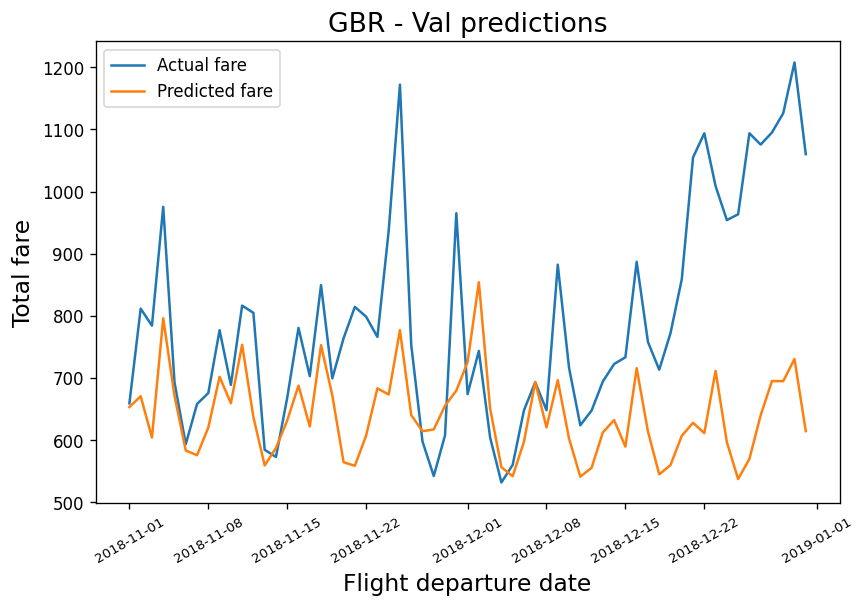

In [40]:
plt.figure(figsize = (8, 5), dpi = 120)
sns.lineplot(
    data = val_df.group_by('flt_departure_dt').agg(pl.col('total_fare').mean()), 
    x = "flt_departure_dt", 
    y = "total_fare",
    label = "Actual fare"
)

sns.lineplot(
    data = val_df.group_by('flt_departure_dt').agg(pl.col('pred_fare').mean()), 
    x = "flt_departure_dt", 
    y = "pred_fare",
    label = "Predicted fare"
)

locs, labels = plt.xticks()
plt.xticks(
    locs,
    [l.get_text() for l in labels],
    rotation = 30,
    fontsize = 8
)

plt.legend()
plt.title("GBR - Val predictions", fontsize = 16)
plt.xlabel("Flight departure date", fontsize = 14)
plt.ylabel("Total fare", fontsize = 14)
plt.show()

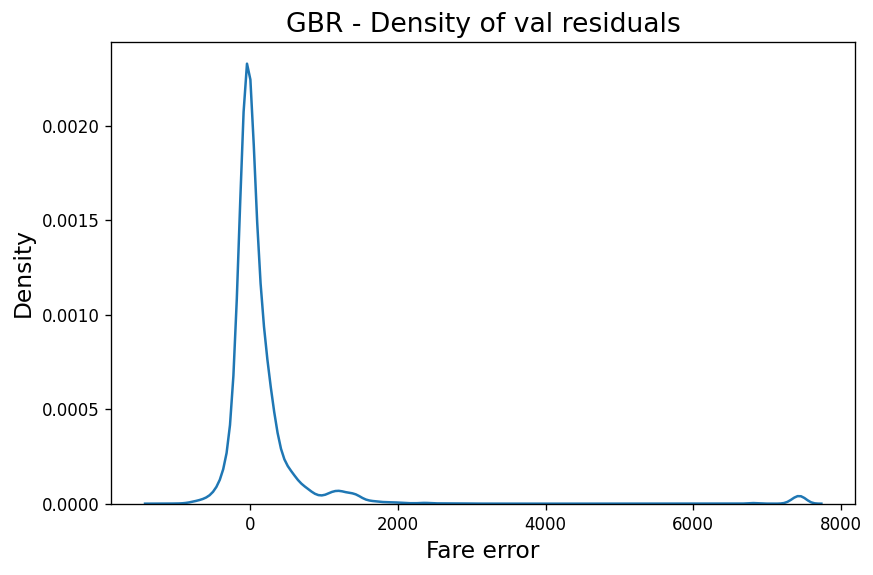

In [47]:
plt.figure(figsize = (8, 5), dpi = 120)
sns.kdeplot(
    val_df['total_fare'] - val_df['pred_fare']
)
plt.title("GBR - Density of val residuals", fontsize = 16)
plt.xlabel("Fare error", fontsize = 14)
plt.ylabel("Density", fontsize = 14)
plt.show()

#### Metrics

##### Overall

In [41]:
print_metrics(
    train_df['total_fare'], train_df['pred_fare'],
    label = 'Train - GBR'
)

print_metrics(
    val_df['total_fare'], val_df['pred_fare'],
    label = 'Val - GBR'
)

Train - GBR
RMSE: 341.3550
MAE: 172.6906
R2: 45.884%

Val - GBR
RMSE: 818.3343
MAE: 279.0656
R2: 5.753%



##### By carrier

In [42]:
for carrier, df in train_df.group_by(['carrier']):
    print_metrics(
        df['total_fare'], df['pred_fare'],
        label = f'Val - Carrier {carrier[0]}'
    )

Val - Carrier L3
RMSE: 429.8137
MAE: 256.6750
R2: 6.553%

Val - Carrier U1
RMSE: 191.9535
MAE: 113.2909
R2: 54.651%

Val - Carrier L2
RMSE: 333.7274
MAE: 137.0246
R2: 45.353%

Val - Carrier U3
RMSE: 178.8797
MAE: 120.4821
R2: 27.785%

Val - Carrier L1
RMSE: 395.5480


MAE: 206.2421
R2: 46.412%

Val - Carrier OTH
RMSE: 173.2586
MAE: 100.7924
R2: 49.029%



In [43]:
for carrier, df in val_df.group_by(['carrier']):
    print_metrics(
        df['total_fare'], df['pred_fare'],
        label = f'Val - Carrier {carrier[0]}'
    )

Val - Carrier U1
RMSE: 207.1126
MAE: 137.0653
R2: 52.980%

Val - Carrier OTH
RMSE: 2640.5906
MAE: 1050.9035
R2: -17.217%

Val - Carrier L3
RMSE: 639.5123
MAE: 380.2684
R2: -2.207%

Val - Carrier L2
RMSE: 251.0147
MAE: 140.0596
R2: 60.672%

Val - Carrier L1
RMSE: 360.3060
MAE: 229.3055
R2: 46.425%

Val - Carrier U3
RMSE: 192.7225
MAE: 141.8078
R2: -21.383%



##### By route

In [44]:
for route_id, df in train_df.group_by(['route_id']):
    print_metrics(
        df['total_fare'], df['pred_fare'],
        label = f'Val - Route {route_id[0]}'
    )

Val - Route 6
RMSE: 300.7215
MAE: 144.0746
R2: 13.673%

Val - Route 9
RMSE: 373.6995
MAE: 181.6739
R2: 51.132%

Val - Route 3
RMSE: 346.5764
MAE: 220.9637
R2: 59.447%

Val - Route 0
RMSE: 391.2031
MAE: 195.0150
R2: 28.480%

Val - Route 4
RMSE: 350.3669
MAE: 168.8935
R2: 13.647%

Val - Route 7
RMSE: 426.8273
MAE: 216.9962
R2: 21.253%

Val - Route 10
RMSE: 356.7456
MAE: 169.0700
R2: 57.981%

Val - Route 1
RMSE: 513.0611
MAE: 254.9010
R2: 33.122%

Val - Route 5
RMSE: 294.9676
MAE: 159.0610
R2: 42.414%

Val - Route 8
RMSE: 563.9177
MAE: 297.8257
R2: 26.588%

Val - Route 2
RMSE: 348.9003
MAE: 227.6520
R2: 51.232%

Val - Route 11
RMSE: 270.9890
MAE: 145.6754
R2: 34.531%



In [45]:
for route_id, df in val_df.group_by(['route_id']):
    print_metrics(
        df['total_fare'], df['pred_fare'],
        label = f'Val - Route {route_id[0]}'
    )

Val - Route 9
RMSE: 236.9503
MAE: 152.8743
R2: 73.928%

Val - Route 3
RMSE: 397.3197
MAE: 269.9470
R2: 50.479%

Val - Route 6
RMSE: 1197.9144
MAE: 356.5990
R2: -4.191%

Val - Route 0
RMSE: 337.8708
MAE: 210.4188
R2: 13.621%

Val - Route 7


RMSE: 370.2631
MAE: 248.0307
R2: 20.164%

Val - Route 1
RMSE: 495.7212
MAE: 357.2621
R2: -4.738%

Val - Route 10
RMSE: 316.4371
MAE: 200.0025
R2: 55.514%

Val - Route 4
RMSE: 1223.7832
MAE: 380.9583
R2: -3.564%

Val - Route 5
RMSE: 297.3169
MAE: 181.1841
R2: 42.968%

Val - Route 2
RMSE: 384.1508
MAE: 270.2530
R2: 43.041%

Val - Route 11
RMSE: 262.4526
MAE: 176.0456
R2: 36.815%

Val - Route 8
RMSE: 448.7246
MAE: 333.0047
R2: 19.262%



In [46]:
pl.DataFrame({
    "Feature": best_model['gbr'].feature_names_in_,
    "FI": (best_model['gbr'].feature_importances_ * 100).round(2)
}).sort("FI", descending = True)

Feature,FI
str,f64
"""remainder__days_till_flight""",35.4
"""remainder__7d_route_carrier_av…",17.62
"""remainder__dur_min""",10.44
"""remainder__7d_route_avg""",10.2
"""remainder__flt_departure_weekd…",9.55
"""remainder__days_since_start""",6.38
"""remainder__route_id""",4.16
"""remainder__destination_id""",2.78
"""remainder__origin_id""",2.02
